In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
name_file_rakuten = 'rakuten_shinchitose.csv'
name_file_jalan = 'jalan_shinchitose.csv'

df_rakuten = pd.read_csv(name_file_rakuten, encoding= 'cp932', index_col=0, dayfirst=True) 
df_jalan = pd.read_csv(name_file_jalan, encoding= 'cp932', index_col=1, dayfirst=True)
analis_column_word = '予約受付日時'
analis_row_word = '予約確認済'

In [3]:
def df_for_analysis(df,analis_column_word,analis_row_word):
    df['date'] = pd.to_datetime(df[analis_column_word]) # преобразем дату заказов
    lst = list(df.index.values.tolist())
    list_index = set(lst) 
    list_index.remove(analis_row_word) # из списка индексов удаляем необходимый
    df.drop(list_index, inplace=True)
    df_for_ds = pd.DataFrame() 
    df_for_ds['count car'] = df.groupby(pd.Grouper(key='date', freq='D')) ['date'].count() # создаем серию с колличеством заказов авто по дням

    
    return df_for_ds

def remove_outlier(df_in, col_name):
       q1 = df_in[col_name].quantile(0.25)
       q3 = df_in[col_name].quantile(0.75)
       iqr = q3-q1 #Interquartile range
       fence_low  = q1-iqr
       fence_high = q3+iqr
       df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
       #df_out = df_in.loc[(df_in[col_name] > 0)]
       return df_out



def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

            count car
date                 
2016-02-16          1
2016-02-17          0
2016-02-18          0
2016-02-19          1
2016-02-20          2
...               ...
2018-12-27          2
2018-12-28          2
2018-12-29          1
2018-12-30          3
2018-12-31          2

[1050 rows x 1 columns]


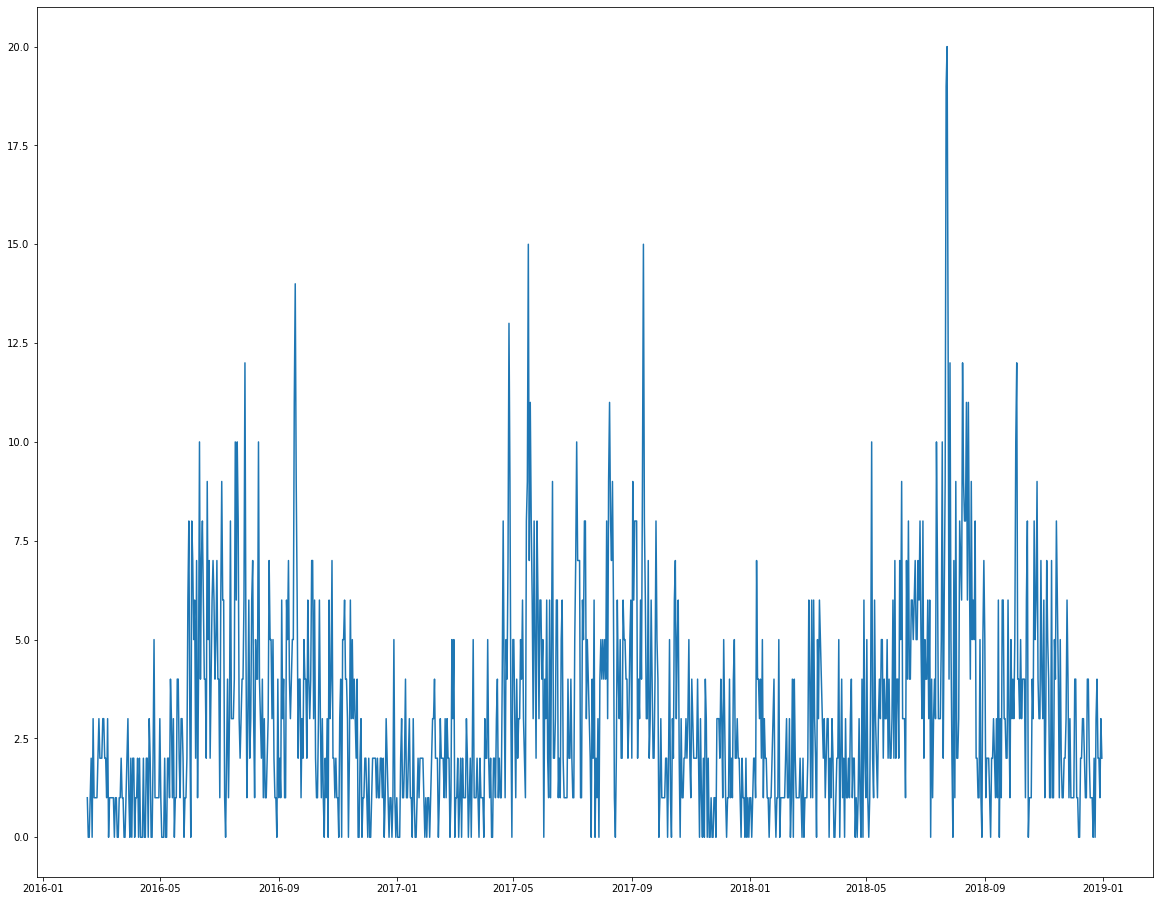

In [4]:
df_rakuten_car = df_for_analysis(df_rakuten,analis_column_word,analis_row_word)
print(df_rakuten_car)
plt.figure(figsize=(20,16))
plt.plot(df_rakuten_car)
plt.show()

            count car
date                 
2016-02-16          1
2016-02-17          0
2016-02-18          0
2016-02-19          1
2016-02-20          2
...               ...
2018-12-27          2
2018-12-28          2
2018-12-29          1
2018-12-30          3
2018-12-31          2

[945 rows x 1 columns]


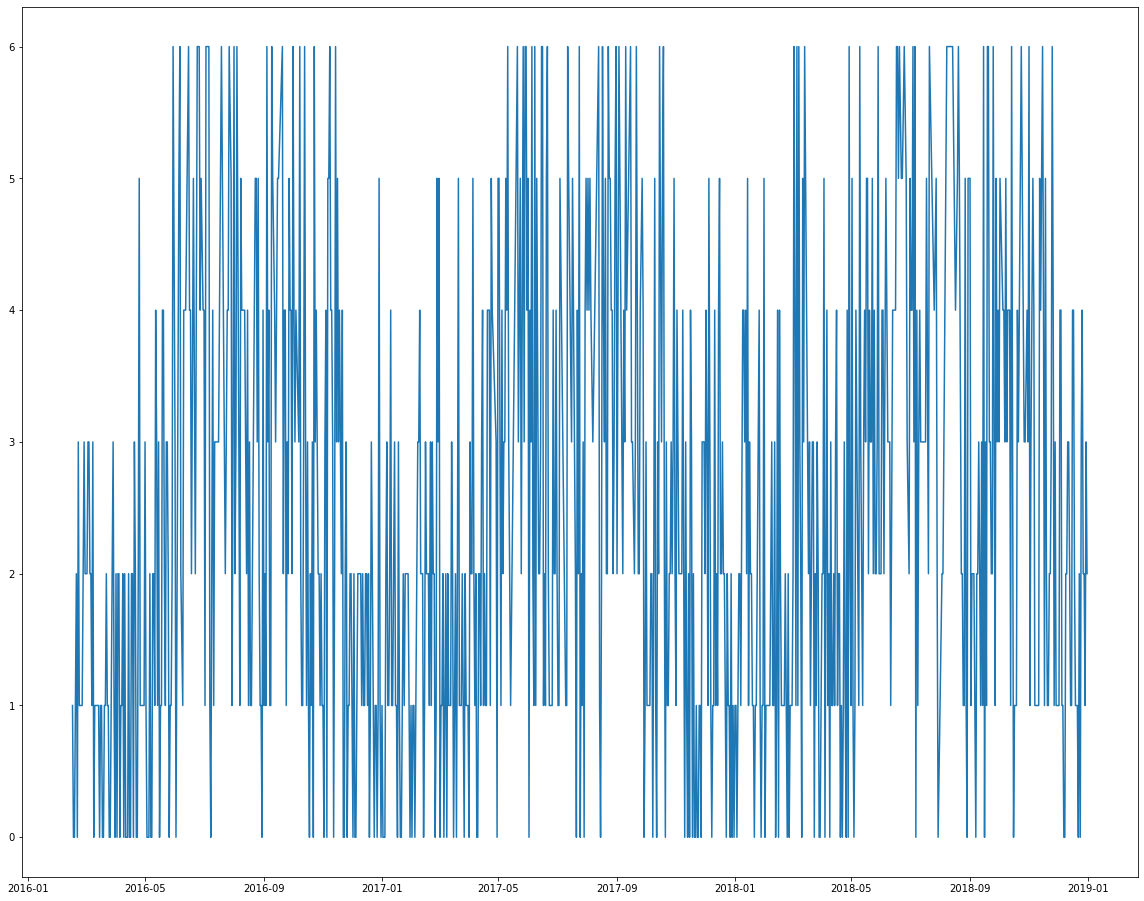

In [5]:
d = remove_outlier(df_rakuten_car, 'count car')
print(d)
plt.figure(figsize=(20,16))
plt.plot(d)
plt.show()

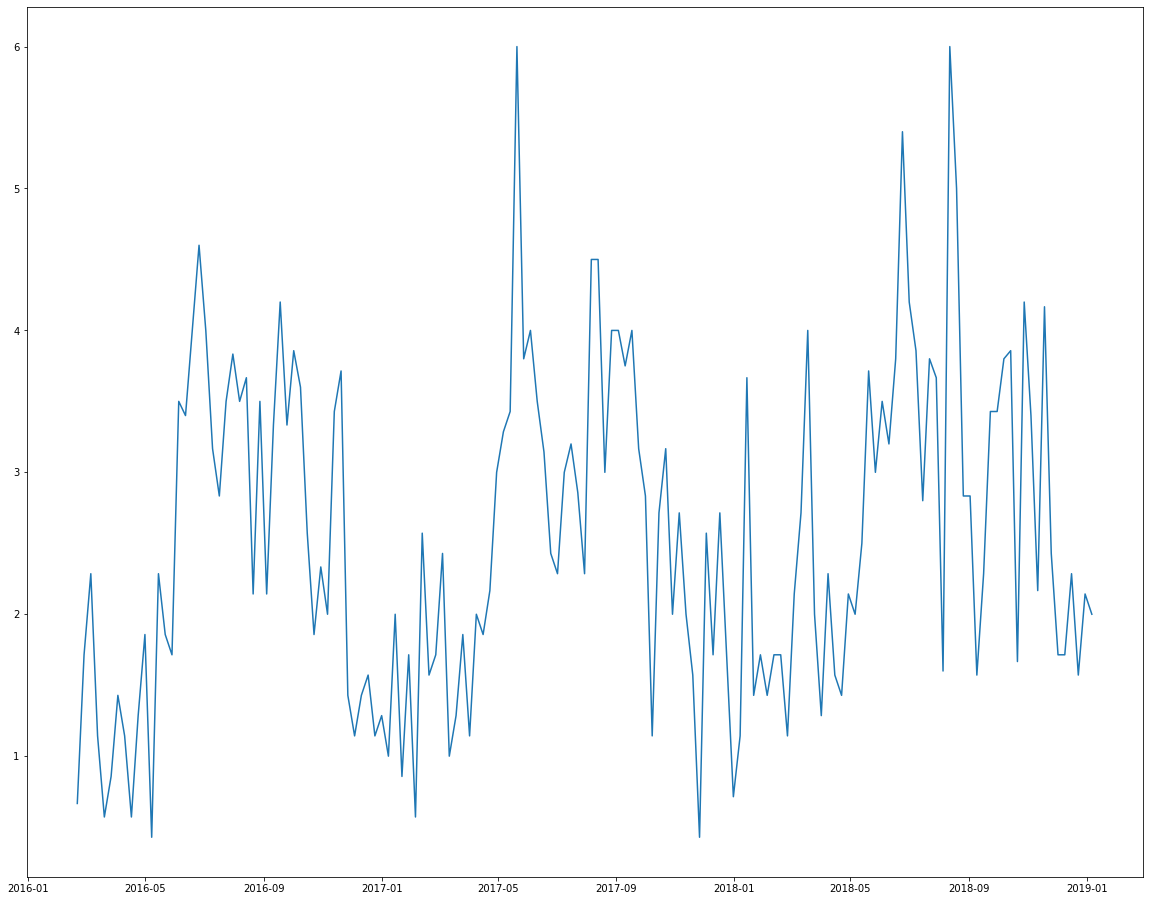

In [6]:
plt.figure(figsize=(20,16))
plt.plot(d.resample('W').mean()) # по неделям
plt.show()

In [7]:
import numpy as np
from statsmodels.iolib.table import SimpleTable
# тест Харки — Бера
row =  ['JB', 'p-value', 'skew', 'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(d) # для определения номарльности распределения, чтобы подтвердить предположение об однородности
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)

          JB         
---------------------
    60.82915320010102
6.181832211398719e-14
   0.5094460612960016
    2.288152948043141
---------------------


<AxesSubplot:ylabel='Density'>

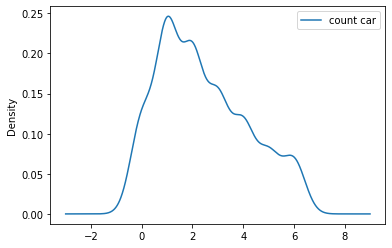

In [8]:
d.plot.kde()

In [12]:
X, y = create_features(d, 'count car')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

C:\Users\GbreH\AppData\Local\Temp\ipykernel_9236\1446531576.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
C:\Users\GbreH\AppData\Local\Temp\ipykernel_9236\1446531576.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df['date'].dt.dayofweek
C:\Users\GbreH\AppData\Local\Temp\ipykernel_9236\1446531576.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [13]:
import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=1000)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

C:\Users\GbreH\Desktop\jupyter\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [14]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
import numpy as np
preds = model.predict(X_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision_Racuten = {}".format(precision_score(y_test, best_preds, average='micro', zero_division=0)))
print("Recall_Racuten = {}".format(recall_score(y_test, best_preds, average='micro')))
print("Accuracy_Racuten = {}".format(accuracy_score(y_test, best_preds)))

Precision_Racuten = 0.11814345991561181
Recall_Racuten = 0.11814345991561181
Accuracy_Racuten = 0.11814345991561181


In [15]:
jalan_analysis_column_word = '申込日'
jalan_analysis_row_word = '予約成立'

def model_predict(df, analysis_column_word, analysis_row_word):
    df_car = df_for_analysis(df, analysis_column_word, analysis_row_word)
    df_rem = remove_outlier(df_car, 'count car')
    x, Y = create_features(df_rem, 'count car')
    x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.25)
    model = xgb.XGBRegressor(n_estimators=1000)
    model.fit(x_train, Y_train,
            eval_set=[(x_train, Y_train), (x_test, Y_test)],
            early_stopping_rounds=50,
        verbose=False) 
    preds = model.predict(x_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    print("Precision = {}".format( precision_score(Y_test, best_preds, average='micro', zero_division=0)))
    print("Recall = {}".format( recall_score(Y_test, best_preds, average='micro')))
    print("Accuracy = {}".format( accuracy_score(Y_test, best_preds)))
    return model

model_predict(df_jalan, jalan_analysis_column_word, jalan_analysis_row_word)

C:\Users\GbreH\AppData\Local\Temp\ipykernel_9236\1446531576.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
C:\Users\GbreH\AppData\Local\Temp\ipykernel_9236\1446531576.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df['date'].dt.dayofweek
C:\Users\GbreH\AppData\Local\Temp\ipykernel_9236\1446531576.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Precision = 0.411522633744856
Recall = 0.411522633744856
Accuracy = 0.411522633744856


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)